In [29]:
import pandas as pd
import numpy as np
from dateutil.relativedelta import *
import seaborn as sns
from pandas import DataFrame
import datetime

# Import necessary libraries
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance

import matplotlib.pyplot as plt
from matplotlib import pyplot
from sklearn import preprocessing


## Load factors and limit data file to only those we want to focus on

In [30]:
factors_load = pd.read_csv(r'C:\Users\anoble\Git\Outside_Work\AFL Fantasy\Data\Inputs\factors.csv')\

## Calcuate most recent year of data for each player, that will be the data we feed into the model
factors_load['recent_season'] = factors_load.groupby(['player_name'])['year'].rank(method="first", ascending=False)

## Remove columns that could be null in 2023, and player names
factors_prep = factors_load.drop(['matches_y','year_int','predicted_year'], axis = 1)

## Join on available players in 2024 season. Split out 2023 factors to run through model

current_players = pd.read_csv(r'C:\Users\anoble\Git\Outside_Work\AFL Fantasy\Data\Inputs\current_players.csv')\

factors_current = factors_prep.merge(current_players, on=['player_name'],how='inner')

factors_prep_23 = factors_current.query('recent_season == 1').drop(['avg_score','recent_season'], axis = 1)

# # Drop nulls (165 rows dropped, leaving 2837 after removing Nulls)
factors_prep = factors_prep.dropna(axis= 0, how='any')
factors_prep_23 = factors_prep_23.dropna(axis= 0, how='any')

## Remove Player Name so it doesn't treat as dummy variable
factors = factors_prep.drop(['player_name'], axis = 1)
factors_23 = factors_prep_23.drop(['player_name'], axis = 1)

# ## Convert position variables into category column. Could also consider category_encoders sklearn package
factors['position_grouped'] = factors['position_grouped'].astype('category')
factors['position_grouped_simple'] = factors['position_grouped_simple'].astype('category')

factors_23['position_grouped'] = factors_23['position_grouped'].astype('category')
factors_23['position_grouped_simple'] = factors_23['position_grouped_simple'].astype('category')


# ## One hot encoding to convert category variables into dummy columns
factors = pd.get_dummies(factors)

factors_23 = pd.get_dummies(factors_23)


print(factors.shape)
print(factors_23.shape)




(3671, 181)
(545, 179)


In [31]:
factors = factors[[
    'avg_score'
    # ,'age_1yr'
    ,'years_active'
    ,'player_height_cm_1yr'
    # ,'player_weight_kg_1yr'
    # ,'afl_fantasy_score_1yr'
    # ,'afl_fantasy_score_3yr'
    # ,'afl_fantasy_score_5yr'
    ,'fantasy_score_yearly_change'
    ,'fantasy_score_yearly_change_exp'
    # ,'fantasy_score_inyear_change'
    ,'kicks_1yr'
    ,'marks_1yr'
    ,'handballs_1yr'
    # ,'disposals_1yr'
    # ,'position_grouped_BP'
    # ,'position_grouped_C'
    # ,'position_grouped_CHB'
    # ,'position_grouped_CHF'
    # ,'position_grouped_FB'
    # ,'position_grouped_FF'
    # ,'position_grouped_FP'
    # ,'position_grouped_HBF'
    # ,'position_grouped_HFF'
    # ,'position_grouped_RUCK'
    # ,'position_grouped_W'
    ,'position_grouped_simple_Key_Position'
    # ,'position_grouped_simple_Centres'
    # ,'position_grouped_simple_Wings_Flank'
    # ,'position_grouped_simple_Ruck'
    # ,'effective_disposals_1yr'
    # ,'disposal_efficiency_percentage_1yr'
    ,'goals_1yr'
    ,'behinds_1yr' 
    ,'hitouts_1yr'
    ,'tackles_1yr'
    # ,'rebounds_1yr'
    # ,'inside_fifties_1yr'
    # ,'clearances_1yr'
    # ,'clangers_1yr'
    # ,'free_kicks_for_1yr'
    # ,'free_kicks_against_1yr'
    # ,'brownlow_votes_1yr'
    ,'contested_possessions_1yr'
    ,'uncontested_possessions_1yr'
    # ,'contested_marks_1yr'
    # ,'marks_inside_fifty_1yr'
    # ,'one_percenters_1yr'
    # ,'bounces_1yr'
    # ,'goal_assists_1yr'
    ,'time_on_ground_percentage_1yr'
    ,'centre_clearances_1yr'
    ,'stoppage_clearances_1yr'
    # ,'score_involvements_1yr'
    # ,'metres_gained_1yr'
    # ,'turnovers_1yr'
    # ,'intercepts_1yr'
    # ,'tackles_inside_fifty_1yr'
    # ,'contest_def_losses_1yr'
    # ,'contest_def_one_on_ones_1yr'
    # ,'contest_off_one_on_ones_1yr'
    # ,'contest_off_wins_1yr'
    # ,'def_half_pressure_acts_1yr'
    ,'effective_kicks_1yr'
    # ,'f50_ground_ball_gets_1yr'
    ,'ground_ball_gets_1yr'
    # ,'hitouts_to_advantage_1yr'
    # ,'hitout_win_percentage_1yr'
    # ,'intercept_marks_1yr'
    # ,'marks_on_lead_1yr'
    # ,'pressure_acts_1yr'
    ,'rating_points_1yr'
    # ,'ruck_contests_1yr'
    # ,'score_launches_1yr'
    # ,'shots_at_goal_1yr'
    # ,'spoils_1yr'
]]

factors

,avg_score,years_active,player_height_cm_1yr,fantasy_score_yearly_change,fantasy_score_yearly_change_exp,kicks_1yr,marks_1yr,handballs_1yr,position_grouped_simple_Key_Position,goals_1yr,...,hitouts_1yr,tackles_1yr,contested_possessions_1yr,uncontested_possessions_1yr,time_on_ground_percentage_1yr,centre_clearances_1yr,stoppage_clearances_1yr,effective_kicks_1yr,ground_ball_gets_1yr,rating_points_1yr
9,77.888889,9,193.0,4.666667,1.855497,10.200000,3.666667,7.866667,False,0.466667,...,0.933333,3.266667,6.466667,11.933333,75.266667,0.600000,1.466667,6.200000,4.533333,9.046667
10,80.500000,9,193.0,4.186186,1.835756,9.888889,4.500000,10.444444,True,0.611111,...,0.111111,2.833333,6.000000,14.777778,78.111111,0.166667,1.277778,6.833333,4.555556,10.722222
11,67.473684,9,193.0,3.388889,1.438798,10.750000,3.916667,10.750000,False,0.333333,...,0.833333,3.583333,8.916667,13.416667,78.666667,0.333333,2.333333,6.500000,5.916667,11.525000
13,86.250000,9,193.0,-0.728228,-0.116622,10.222222,3.722222,7.666667,False,0.111111,...,0.555556,2.500000,5.888889,12.000000,78.833333,0.000000,1.500000,6.166667,4.444444,6.422222
14,86.958333,9,193.0,9.565789,-0.889287,14.350000,5.750000,7.350000,False,0.300000,...,0.000000,2.700000,6.200000,15.500000,80.450000,0.150000,1.650000,10.300000,4.350000,8.840000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5723,89.263158,11,175.0,0.173913,-4.041948,16.782609,5.304348,7.347826,False,0.739130,...,0.000000,6.086957,9.565217,13.608696,82.608696,1.956522,2.565217,10.260870,6.869565,16.226087
5724,85.000000,11,175.0,-9.593985,-4.244277,15.842105,6.263158,5.526316,False,0.315789,...,0.000000,3.210526,6.210526,14.421053,78.000000,0.894737,1.789474,11.000000,4.315789,11.442105
5727,59.000000,6,190.0,0.969970,0.138540,8.611111,3.944444,4.000000,True,1.722222,...,0.000000,3.000000,4.944444,7.833333,81.944444,0.222222,0.722222,5.166667,2.833333,8.161111
5728,65.466667,6,190.0,-3.351351,0.587065,8.157895,3.789474,3.736842,True,1.789474,...,0.000000,1.631579,6.000000,6.105263,84.578947,0.052632,0.947368,4.578947,3.368421,8.410526


In [32]:
factors_23 = factors_23[[
    #    'age_1yr'
     'years_active'
    ,'player_height_cm_1yr'
    # ,'player_weight_kg_1yr'
    # ,'afl_fantasy_score_1yr'
    # ,'afl_fantasy_score_3yr'
    # ,'afl_fantasy_score_5yr'
    ,'fantasy_score_yearly_change'
    ,'fantasy_score_yearly_change_exp'
    # ,'fantasy_score_inyear_change'
    ,'kicks_1yr'
    ,'marks_1yr'
    ,'handballs_1yr'
    # ,'disposals_1yr'
    # ,'position_grouped_BP'
    # ,'position_grouped_C'
    # ,'position_grouped_CHB'
    # ,'position_grouped_CHF'
    # ,'position_grouped_FB'
    # ,'position_grouped_FF'
    # ,'position_grouped_FP'
    # ,'position_grouped_HBF'
    # ,'position_grouped_HFF'
    # ,'position_grouped_RUCK'
    # ,'position_grouped_W'
    ,'position_grouped_simple_Key_Position'
    # ,'position_grouped_simple_Centres'
    # ,'position_grouped_simple_Wings_Flank'
    # ,'position_grouped_simple_Ruck'
    # ,'effective_disposals_1yr'
    # ,'disposal_efficiency_percentage_1yr'
    ,'goals_1yr'
    ,'behinds_1yr' 
    ,'hitouts_1yr'
    ,'tackles_1yr'
    # ,'rebounds_1yr'
    # ,'inside_fifties_1yr'
    # ,'clearances_1yr'
    # ,'clangers_1yr'
    # ,'free_kicks_for_1yr'
    # ,'free_kicks_against_1yr'
    # ,'brownlow_votes_1yr'
    ,'contested_possessions_1yr'
    ,'uncontested_possessions_1yr'
    # ,'contested_marks_1yr'
    # ,'marks_inside_fifty_1yr'
    # ,'one_percenters_1yr'
    # ,'bounces_1yr'
    # ,'goal_assists_1yr'
    ,'time_on_ground_percentage_1yr'
    ,'centre_clearances_1yr'
    ,'stoppage_clearances_1yr'
    # ,'score_involvements_1yr'
    # ,'metres_gained_1yr'
    # ,'turnovers_1yr'
    # ,'intercepts_1yr'
    # ,'tackles_inside_fifty_1yr'
    # ,'contest_def_losses_1yr'
    # ,'contest_def_one_on_ones_1yr'
    # ,'contest_off_one_on_ones_1yr'
    # ,'contest_off_wins_1yr'
    # ,'def_half_pressure_acts_1yr'
    ,'effective_kicks_1yr'
    # ,'f50_ground_ball_gets_1yr'
    ,'ground_ball_gets_1yr'
    # ,'hitouts_to_advantage_1yr'
    # ,'hitout_win_percentage_1yr'
    # ,'intercept_marks_1yr'
    # ,'marks_on_lead_1yr'
    # ,'pressure_acts_1yr'
    ,'rating_points_1yr'
    # ,'ruck_contests_1yr'
    # ,'score_launches_1yr'
    # ,'shots_at_goal_1yr'
    # ,'spoils_1yr'
    ]]

factors_23

,years_active,player_height_cm_1yr,fantasy_score_yearly_change,fantasy_score_yearly_change_exp,kicks_1yr,marks_1yr,handballs_1yr,position_grouped_simple_Key_Position,goals_1yr,behinds_1yr,hitouts_1yr,tackles_1yr,contested_possessions_1yr,uncontested_possessions_1yr,time_on_ground_percentage_1yr,centre_clearances_1yr,stoppage_clearances_1yr,effective_kicks_1yr,ground_ball_gets_1yr,rating_points_1yr
6,9,193.0,6.297043,-1.634511,12.958333,5.583333,10.166667,False,0.416667,0.208333,0.000000,2.416667,7.458333,15.791667,85.541667,0.250000,2.083333,8.000000,5.791667,10.479167
17,11,181.0,-9.775920,-1.245135,9.652174,3.391304,8.782609,True,0.565217,0.478261,0.000000,4.565217,7.913043,10.739130,76.260870,1.565217,2.130435,5.086957,5.434783,9.639130
23,7,183.0,9.262626,-0.116622,8.444444,4.555556,4.222222,False,0.444444,0.555556,0.000000,3.000000,5.333333,7.888889,72.333333,0.222222,0.888889,5.777778,3.222222,7.255556
29,6,178.0,0.628571,1.054985,10.857143,4.761905,6.809524,False,1.000000,0.714286,0.000000,1.857143,6.476190,11.476190,82.000000,0.380952,0.809524,7.238095,5.380952,9.995238
38,9,183.0,0.092308,-1.634511,11.200000,4.000000,8.600000,False,0.200000,0.200000,0.000000,2.450000,5.850000,13.650000,82.000000,0.400000,1.450000,7.300000,4.450000,8.745000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2656,6,202.0,1.553571,0.256549,7.714286,5.285714,5.714286,True,0.000000,0.142857,4.142857,1.142857,4.857143,7.785714,90.714286,0.214286,0.285714,5.428571,2.928571,9.135714
2657,1,196.0,0.000000,0.256549,6.789474,2.894737,2.526316,True,0.000000,0.000000,0.000000,1.210526,4.000000,4.736842,88.526316,0.000000,0.157895,4.368421,2.631579,7.994737
2660,4,195.0,0.877273,0.256549,7.454545,5.454545,4.681818,True,0.000000,0.000000,0.000000,1.500000,4.954545,7.227273,91.090909,0.000000,0.136364,6.090909,3.409091,9.959091
2671,11,175.0,-9.864407,-3.000000,13.764706,6.058824,5.058824,False,0.352941,0.294118,0.000000,3.764706,5.529412,12.529412,76.705882,0.764706,1.352941,8.764706,3.705882,8.352941


In [33]:
# Load your dataset

y = factors['avg_score']

X = factors.drop(['avg_score'], axis = 1)

X_new = factors_23

## Standardise factors between 0 and 1
scaler = preprocessing.MinMaxScaler()

d = scaler.fit_transform(X)
X = pd.DataFrame(d, columns=X.columns)

## Scale 2023 factors for predictions as well
d_new = scaler.fit_transform(X_new)
X_new = pd.DataFrame(d_new, columns=X_new.columns)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

params = {
    "n_estimators": 50,
    "max_depth": 3,
    "min_samples_split": 5,
    "learning_rate": 0.1,
    "loss": "squared_error",
}

# Initialize the GBM model
gbm = GradientBoostingRegressor(**params)

# Train the model
gbm.fit(X_train, y_train)

# Make predictions
y_pred = gbm.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 106.01482106526333


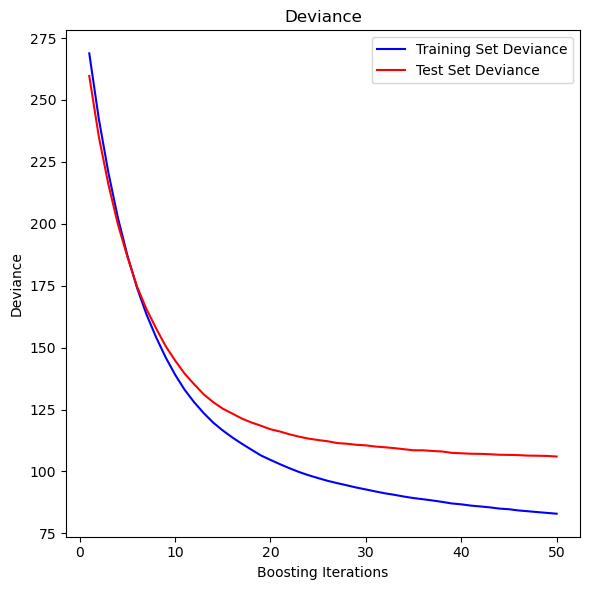

In [34]:
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(gbm.staged_predict(X_test)):
    test_score[i] = mean_squared_error(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    gbm.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
fig.tight_layout()
plt.show()

In [35]:
# factors_np = np.factors


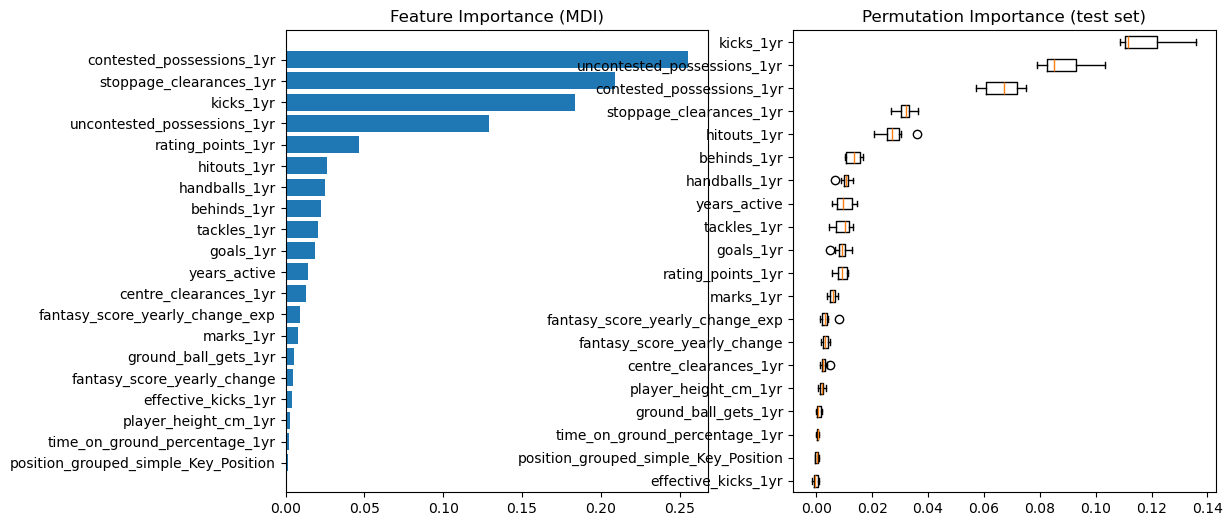

In [36]:
feature_importance = gbm.feature_importances_
sorted_idx = np.argsort(feature_importance)

## Col Names
X_train_cols = (X_train.keys())

pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(X_train_cols)[sorted_idx])
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    gbm, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(X_train_cols)[sorted_idx],
)
plt.title("Permutation Importance (test set)")
# fig.tight_layout()
plt.show()

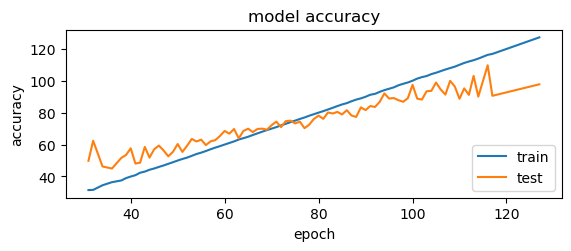

In [37]:
#comparing y-value actual and prediction of testing data
df_compare = pd.DataFrame({'Actual' : y_test, 'Prediction': y_pred})

model_output = df_compare.join(factors_load, lsuffix='_caller', rsuffix='_other', how='inner')

acc_chart = model_output.groupby(round(model_output['Actual'])).agg({'Prediction': 'mean', 'Actual': 'mean'})

# acc_chart.sort_values(by=['Actual'], ascending=True)

plt.subplot(2,1,1)
plt.plot(acc_chart['Actual'])
plt.plot(acc_chart['Prediction'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')


## Predict 2024 scores

In [38]:
# Make predictions
y_pred_new = gbm.predict(X_new)
y_pred_new = pd.DataFrame({'Predicted' : y_pred_new})

X_new_reset = X_new.reset_index()
factors_23_reset = factors_prep_23.reset_index()

pred_output = y_pred_new.join(factors_23_reset, lsuffix='_caller', rsuffix='_other', how='left')

# Write predictions to csv
# pred_output.to_csv(r'C:\Users\anoble\Git\Outside_Work\AFL Fantasy\Data\Outputs\Model_pred_GBM.csv')

print(factors_prep_23.shape)
print(X_new.shape)

(545, 167)
(545, 20)


In [39]:
## Sort by highest predicted score
pd.set_option('display.max_rows', 80)

pred_output['upside'] = pred_output['Predicted'] - pred_output['afl_fantasy_score_1yr']

pred_output[['player_name','age_1yr', 'position_grouped','matches_x','Predicted','afl_fantasy_score_1yr', 'upside']]\
.sort_values(by=['Predicted'], ascending=False).head(20)

# .query('position_grouped in "RUCK"')\

,player_name,age_1yr,position_grouped,matches_x,Predicted,afl_fantasy_score_1yr,upside
447,"Serong, Caleb",22.0,C,22,108.893506,108.090909,0.802597
126,"Davies-Uniacke, Luke",24.0,C,14,108.496611,97.428571,11.068040
379,"Oliver, Clayton",26.0,C,15,107.526832,115.066667,-7.539835
191,"Green, Tom",22.0,C,22,107.233003,108.727273,-1.494269
47,"Brayshaw, Andrew",24.0,C,23,106.145965,110.347826,-4.201862
384,"Parish, Darcy",26.0,C,18,105.756751,106.888889,-1.132138
503,"Walsh, Sam",23.0,C,17,105.576038,100.588235,4.987803
486,"Taranto, Tim",25.0,C,23,105.189736,112.434783,-7.245047
351,"Miller, Touk",27.0,C,12,104.960802,100.166667,4.794135
395,"Petracca, Christian",27.0,C,25,104.378863,104.720000,-0.341137


In [40]:
pred_output[['player_name','age_1yr', 'position_grouped','matches_x','Predicted','afl_fantasy_score_1yr', 'upside']]\
.query('Predicted >= 80')\
.sort_values(by=['upside'], ascending=False).head(50)

,player_name,age_1yr,position_grouped,matches_x,Predicted,afl_fantasy_score_1yr,upside
175,"Fyfe, Nat",32.0,C,5,81.090484,60.800000,20.290484
529,"Wines, Ollie",29.0,C,25,92.317069,75.160000,17.157069
257,"Jones, Zak",27.0,C,10,86.391035,70.700000,15.691035
176,"Gaff, Andrew",31.0,W,23,87.130419,71.695652,15.434767
534,"Worpel, James",24.0,C,23,101.525463,86.260870,15.264593
136,"Dow, Paddy",24.0,C,6,89.651310,74.500000,15.151310
1,"Adams, Taylor",30.0,FP,23,90.502724,75.608696,14.894028
364,"Narkle, Quinton",24.0,C,6,89.661090,74.833333,14.827757
399,"Phillips, Will",21.0,C,14,86.297146,71.500000,14.797146
151,"Ellis, Brandon",30.0,W,16,89.850832,75.625000,14.225832


In [41]:
## Inner join to player who are listed in the best 22. Exclude players flagged due to position changes, injuries, or ages being too high 
player_lineup = pd.read_csv(r'C:\Users\anoble\Git\Outside_Work\AFL Fantasy\Data\Inputs\players_in_lineup.csv')\
                        .query('Inclusion == "Yes"')


pred_output = pred_output.merge(player_lineup, on=['player_name'], how='inner')

pred_output.to_csv(r'C:\Users\anoble\Git\Outside_Work\AFL Fantasy\Data\Outputs\predictions_GBM_pre.csv',mode='w+')
pred_output

,Predicted,index,Unnamed: 0,player_name,matches_x,year_played,years_active,year,position_grouped,position_grouped_simple,...,ruck_contests_5yr,score_launches_5yr,shots_at_goal_5yr,spoils_5yr,afl_fantasy_score_5yr,fantasy_score_yearly_change,fantasy_score_inyear_change,fantasy_score_yearly_change_exp,upside,Inclusion
0,91.345000,6,15,"Acres, Blake",24,2023.0,9,2023,W,Wings_Flank,...,2.259259,1.086420,0.790123,0.876543,77.567901,6.297043,-4.583333,-1.634511,4.386667,Yes
1,65.626203,23,52,"Ah Chee, Callum",9,2023.0,7,2023,HFF,Wings_Flank,...,0.000000,0.777778,0.711111,0.933333,50.444444,9.262626,0.000000,-0.116622,6.181758,Yes
2,78.619253,29,59,"Ainsworth, Ben",21,2023.0,6,2023,HFF,Wings_Flank,...,0.000000,0.600000,2.257143,0.300000,73.128571,0.628571,8.634615,1.054985,4.524015,Yes
3,82.332857,38,68,"Aish, James",20,2023.0,9,2023,W,Wings_Flank,...,0.000000,0.756410,0.461538,1.025641,72.602564,0.092308,3.000000,-1.634511,8.932857,Yes
4,61.606968,44,74,"Aliir, Aliir",24,2023.0,7,2023,BP,Key_Position,...,4.752809,1.056180,0.101124,5.573034,58.887640,-6.714552,7.350000,-0.834840,11.231968,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330,91.293201,2651,5681,"Young, Hayden",22,2023.0,3,2023,BP,Key_Position,...,0.000000,1.078431,0.176471,1.588235,87.490196,1.737077,-0.133333,1.835756,2.065928,Yes
331,59.099423,2656,5689,"Young, Lewis",14,2023.0,6,2023,FB,Key_Position,...,8.422222,1.066667,0.155556,8.022222,55.644444,1.553571,-12.333333,0.256549,1.170851,Yes
332,46.473296,2657,5692,"Young, Tylar",19,2023.0,1,2023,BP,Key_Position,...,0.000000,0.789474,0.000000,7.105263,36.894737,0.000000,4.474359,0.256549,9.578559,Yes
333,54.534340,2660,5703,"Zerk-Thatcher, Brandon",22,2023.0,4,2023,FB,Key_Position,...,0.048780,0.926829,0.000000,5.512195,51.463415,0.877273,0.760684,0.256549,2.307067,Yes
